**By Huy Duc Vu - 25728181**

# Part 3: Machine Learning

## 3.1.a. Calculate RMSE (baseline) from P2.3.c

In [0]:
%sql
CREATE OR REPLACE TEMPORARY VIEW baseline_pred AS
WITH
trip_group AS (
  SELECT color,
        PU_Borough,
        DR_Borough,
        YEAR(pickup_dt) AS y,
        MONTH(pickup_dt) AS m,
        DAYOFWEEK(pickup_dt) AS dow,
        HOUR(pickup_dt) AS hr, 
        total_amount
  FROM bde.final_trips_cleaned
  WHERE NOT (year(pickup_dt) = 2024 AND month(pickup_dt) IN (10,11,12))
),

derived_avg AS (
  SELECT color,
        PU_Borough,
        DR_Borough,
        y, m, dow, hr,
        AVG(total_amount) AS average_amount_per_trip
  FROM trip_group
  GROUP BY color, PU_Borough, DR_Borough, y, m, dow, hr
)

SELECT t.color,
      t.PU_Borough,
      t.DR_Borough,
      t.y, t.m, t.dow, t.hr,
      t.total_amount AS actual_total,
      a.average_amount_per_trip AS predicted_total
FROM derived_avg a JOIN trip_group t
    ON t.color = a.color
    AND t.PU_Borough = a.PU_Borough
    AND t.DR_Borough = a.DR_Borough
    AND t.y = a.y
    AND t.m = a.m
    AND t.dow = a.dow
    AND t.hr = a.hr
;

In [0]:
%sql
--Calculate RMSE for baseline
SELECT SQRT(AVG(POW(actual_total - predicted_total, 2))) AS baseline_rmse
FROM baseline_pred;

baseline_rmse
8.170556079482477


## 3.2.b. ML models

### i. Dataset preparation

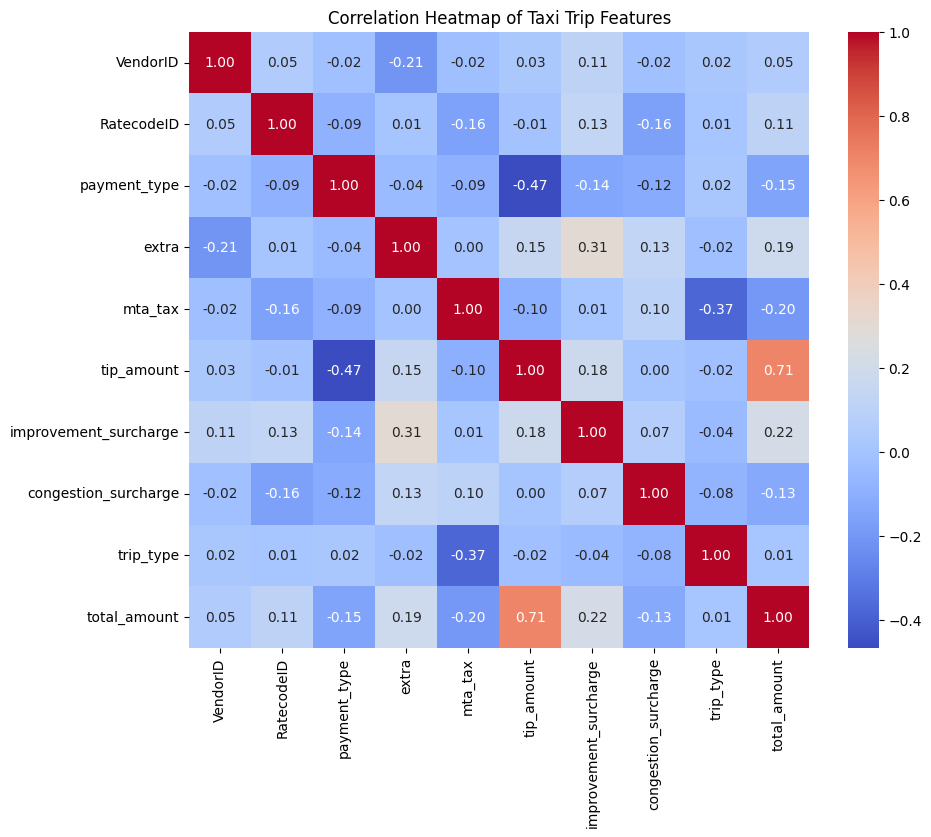

In [0]:
# Check correlations between variables for feature selection

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F

df_num = (
    spark.table("bde.final_trips_cleaned")
    .select(
        "VendorID",
        "RatecodeID",
        "payment_type",
        "extra",
        "mta_tax",
        "tip_amount",
        "improvement_surcharge",
        "congestion_surcharge",
        "trip_type",
        "total_amount"
    )
    .sample(
        fraction=0.05, 
        seed=42
    )
    .toPandas()
)

corr = df_num.corr()

plt.figure(figsize=(10,8))
sns.heatmap(
    corr, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar=True
)
plt.title("Correlation Heatmap of Taxi Trip Features")
plt.show()

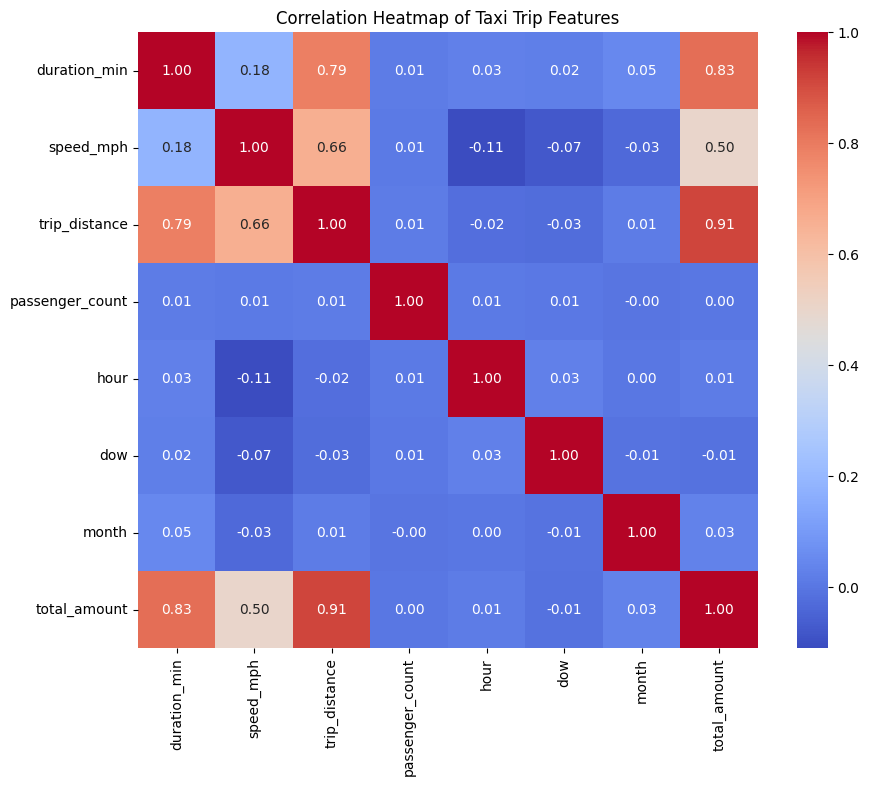

In [0]:
# Check correlations between variables for feature selection

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F

df_num = (
    spark.table("bde.final_trips_cleaned")
    .select(
        (
            (F.unix_timestamp("dropoff_dt") - F.unix_timestamp("pickup_dt")) / F.lit(60.0)
        ).alias("duration_min"),
        (
            (F.col("trip_distance").cast("double") / 
             ((F.unix_timestamp("dropoff_dt") - F.unix_timestamp("pickup_dt")) / F.lit(3600.0)))
        ).alias("speed_mph"),
        F.col("trip_distance").cast("double").alias("trip_distance"),
        "passenger_count", 
        F.hour("pickup_dt").alias("hour"),
        F.dayofweek("pickup_dt").alias("dow"),
        F.month("pickup_dt").alias("month"),
        "total_amount"
    )
    .sample(
        fraction=0.05, 
        seed=42
    )
    .toPandas()
)

corr = df_num.corr()

plt.figure(figsize=(10,8))
sns.heatmap(
    corr, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar=True
)
plt.title("Correlation Heatmap of Taxi Trip Features")
plt.show()

In [0]:
# Feature engineering (NO leakage cols)

from pyspark.sql import functions as F

data = "bde.final_trips_cleaned"

df = (
  spark.table(data)
  .select(
      "color", "PU_Borough", "DR_Borough",
      "pickup_dt", "dropoff_dt",
      "trip_distance",          
      "payment_type",
      "total_amount"              # target
      #"trip_type", "ratecodeid", "vendorid",
  )
  .withColumn("duration_min", (F.unix_timestamp("dropoff_dt") - F.unix_timestamp("pickup_dt")) / F.lit(60.0))
  # .withColumn("speed_mph", (F.col("trip_distance").cast("double") / ((F.unix_timestamp("dropoff_dt") - F.unix_timestamp("pickup_dt")) / F.lit(3600.0))))
  # .withColumn("hour", F.hour("pickup_dt"))
  # .withColumn("dow", F.dayofw eek("pickup_dt"))       
  .withColumn("month", F.month("pickup_dt"))
  .withColumn("same_borough", F.when(F.col("PU_Borough")==F.col("DR_Borough"), F.lit(1)).otherwise(F.lit(0)))

  .where(
      F.col("duration_min") > 0
  )
)

In [0]:
# Train/Test split by date rule
train = df.where(~((F.year("pickup_dt")==F.lit(2024)) & (F.col("month").isin(10,11,12))))
test  = df.where(  (F.year("pickup_dt")==F.lit(2024)) & (F.col("month").isin(10,11,12)))

print("Train rows:", train.count(), " Test rows:", test.count())

Train rows: 959568372  Test rows: 10770418


### ii. Linear Regression Model

In [0]:
# Model 1: ElasticNet with recent-year filter + sampling + time-based validation
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit, RandomizedSearchCV
from scipy.stats import loguniform, uniform
from pyspark.sql import functions as F

In [0]:
# tune data selection for memory efficiency
YEAR_MIN = 2023          
SAMPLE_FRACTION = 0.10   
VAL_START = "2024-07-01" # time-based validation window inside TRAIN
VAL_END   = "2024-09-30"
N_SEARCH_ITERS   = 4       # very small randomized search
MAX_ITER_MODEL   = 2000    # fewer iterations for ElasticNet

cat_cols = ["color", "PU_Borough", "DR_Borough", "payment_type"]
num_cols = ["trip_distance", "duration_min", "same_borough"]
label    = "total_amount"
cols_for_pd = ["pickup_dt"] + cat_cols + num_cols + [label]

In [0]:
# Reduce TRAIN before collecting: recent years + sample
train_recent = train.where(F.year("pickup_dt") >= YEAR_MIN)
if SAMPLE_FRACTION < 1.0:
    train_recent = train_recent.sample(fraction=float(SAMPLE_FRACTION), seed=42)

# TEST is already Oct–Dec 2024 per your split; keep entire test for evaluation
test_recent = test

In [0]:
# Collect to pandas (only needed columns)
train_pd = train_recent.select(*cols_for_pd).toPandas()
test_pd  = test_recent.select(*cols_for_pd).toPandas()


In [0]:
# Light cleanup
train_pd["pickup_dt"] = pd.to_datetime(train_pd["pickup_dt"])
test_pd["pickup_dt"]  = pd.to_datetime(test_pd["pickup_dt"])

print("Train/Test shapes after reduction:", train_pd.shape, test_pd.shape)

Train/Test shapes after reduction: (6685455, 9) (10770418, 9)


In [0]:
# Build explicit TIME-BASED validation split inside TRAIN (Jul–Sep 2024)
val_start = pd.Timestamp(VAL_START)
val_end   = pd.Timestamp(VAL_END) + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)

is_val = (train_pd["pickup_dt"] >= val_start) & (train_pd["pickup_dt"] <= val_end)
X_train_sub = train_pd.loc[~is_val, cat_cols + num_cols]
y_train_sub = train_pd.loc[~is_val, label]
X_val       = train_pd.loc[ is_val, cat_cols + num_cols]
y_val       = train_pd.loc[ is_val, label]

# Concatenate and mark PredefinedSplit: -1=train fold, 0=validation fold
X_cv = pd.concat([X_train_sub, X_val], axis=0)
y_cv = pd.concat([y_train_sub, y_val], axis=0)
test_fold = np.concatenate([np.full(len(X_train_sub), -1), np.zeros(len(X_val))]).astype(int)
predef = PredefinedSplit(test_fold)

print(f"Sub-train: {len(X_train_sub):,} | Val: {len(X_val):,} | Using PredefinedSplit")


Sub-train: 5,746,074 | Val: 939,381 | Using PredefinedSplit


In [0]:
# sklearn pipeline: OHE(cats) + Scale(nums) + ElasticNet
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols),
        ("num", StandardScaler(with_mean=False), num_cols),
    ],
    remainder="drop",
    sparse_threshold=1.0,  # stay sparse for memory efficiency
)

enet = ElasticNet(max_iter=MAX_ITER_MODEL, random_state=42)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", enet),
])


In [0]:
# Randomized search over a sensible space
param_dist = {
    # alpha > 0; use loguniform for breadth but few samples
    "model__alpha":    loguniform(1e-2, 1e1),    # ~[0.01 .. 10]
    "model__l1_ratio": uniform(0.0, 1.0),        # [0..1] ridge..lasso
}

rs = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=N_SEARCH_ITERS,
    scoring="neg_root_mean_squared_error",
    cv=predef,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rs.fit(X_cv, y_cv)
print("Best params:", rs.best_params_)
print("Best CV RMSE:", -rs.best_score_)

best_enet = rs.best_estimator_


Fitting 1 folds for each of 4 candidates, totalling 4 fits
Best params: {'model__alpha': 0.014936568554617643, 'model__l1_ratio': 0.8661761457749352}
Best CV RMSE: 6.627933710291085


In [0]:
# Refit on FULL (reduced) TRAIN and evaluate on TEST (Oct–Dec 2024)
X_train_full = train_pd[cat_cols + num_cols]
y_train_full = train_pd[label]
X_test       = test_pd[cat_cols + num_cols]
y_test       = test_pd[label]

best_enet.fit(X_train_full, y_train_full)
pred_test = best_enet.predict(X_test)

rmse = root_mean_squared_error(y_test, pred_test)
mae  = mean_absolute_error(y_test, pred_test)
r2   = r2_score(y_test, pred_test)
print(f"[ElasticNet] Test RMSE: {rmse:,.3f} | MAE: {mae:,.3f} | R²: {r2:,.3f}")


[ElasticNet] Test RMSE: 6.646 | MAE: 3.505 | R²: 0.904


### iii. RandomForest (tree-based)

In [0]:
# Model 2: RandomForest (dense-friendly) with OrdinalEncoder + time-based validation 
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from scipy.stats import randint, uniform
from pyspark.sql import functions as F

In [0]:
# Dense-friendly preprocessing: Ordinal-encode categoricals (handle unknowns as -1). No scaling for trees.
preprocess_dense = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42
)

pipe_rf = Pipeline(steps=[
    ("prep", preprocess_dense),
    ("model", rf),
])


In [0]:
# Small randomized search
param_dist = {
    "model__n_estimators": randint(150, 300),
    "model__max_depth":    randint(8, 20),
    "model__min_samples_leaf": randint(2, 10),
    "model__max_features":  uniform(0.4, 0.6),  
}

rs = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=param_dist,
    n_iter=N_SEARCH_ITERS,
    scoring="neg_root_mean_squared_error",
    cv=predef,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rs.fit(X_cv, y_cv)
print("[RF] Best params:", rs.best_params_)
print("[RF] Best CV RMSE:", -rs.best_score_)

best_rf = rs.best_estimator_


Fitting 1 folds for each of 4 candidates, totalling 4 fits
[RF] Best params: {'model__max_depth': 15, 'model__max_features': 0.759195090518222, 'model__min_samples_leaf': 8, 'model__n_estimators': 271}
[RF] Best CV RMSE: 5.137998020463187


In [0]:
# Refit on FULL (capped) TRAIN and evaluate on TEST (Oct–Dec 2024)
X_train_full = train_pd[cat_cols + num_cols]
y_train_full = train_pd[label]
X_test       = test_pd[cat_cols + num_cols]
y_test       = test_pd[label]

best_rf.fit(X_train_full, y_train_full)
pred_test_rf = best_rf.predict(X_test)

rmse_rf = root_mean_squared_error(y_test, pred_test_rf)
mae_rf  = mean_absolute_error(y_test, pred_test_rf)
r2_rf   = r2_score(y_test, pred_test_rf)
print(f"[RandomForest] Test RMSE: {rmse_rf:,.3f} | MAE: {mae_rf:,.3f} | R²: {r2_rf:,.3f}")



[RandomForest] Test RMSE: 5.134 | MAE: 2.424 | R²: 0.943


In [0]:
# Quick feature importances (joined cat+num names after encoding)
feature_names = cat_cols + num_cols  # after OrdinalEncoder + passthrough
importances = best_rf.named_steps["model"].feature_importances_
top_idx = np.argsort(importances)[::-1][:15]
print("\nTop features (RF):")
for i in top_idx:
    print(f"{feature_names[i]:<20}  {importances[i]:.4f}")


Top features (RF):
trip_distance         0.6589
same_borough          0.1794
duration_min          0.1241
DR_Borough            0.0183
payment_type          0.0118
PU_Borough            0.0072
color                 0.0003
